In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import pandas 

from lib import loading

df = loading.load_data()
print("We have {0} labelled examples.".format(len(df)))

Read the data file from ./airline-twitter-sentiment/Tweets.csv
We have 14640 labelled examples.


## Sentiment distribution

(-1.0134973589447356,
 1.0000000209436062,
 -1.0104870255027887,
 1.0085293797545596)

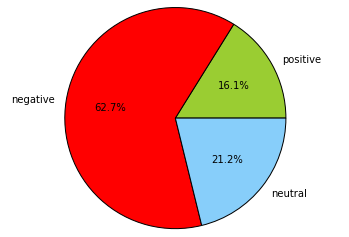

In [2]:
%matplotlib inline
labels = ['positive', 'negative', 'neutral']
sizes = [sum(df['airline_sentiment'] == label) for label in labels]
colors = ['yellowgreen', 'red', 'lightskyblue']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.axis('equal')


## Word frequency distribution

We are interested in the terms frequency distribution since we want to know what frequency we should make the cut-off.
We eliminated stop words and tokenized the tweets using the TweetTokenizer provided by NLTK.


In [3]:
from lib import processing

data = processing.process_data(df)

from wordcloud import WordCloud, STOPWORDS
from scipy.misc import imread
import random

def plot_word_cloud(l):
    twitter_mask = imread('./twitter_mask.png', flatten=True)
    
    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          max_words = 200,
                          mask = twitter_mask,
                          random_state = 3,
                         )
    wc = wordcloud.generate_from_frequencies(l.items())


    plt.figure(figsize=(12, 12))
    plt.axis("off")
    plt.imshow(wc, cmap=plt.cm.gray, interpolation='bilinear')
    plt.autoscale(True)

Using a total of 14640 tweets


## Visualizing most used unigrams and bigrams

In [4]:
from collections import defaultdict

unigrams = defaultdict(int)
bigrams = defaultdict(int)
for tokens, _ in data:
    for i, token in enumerate(tokens):
        unigrams[token] += 1
        if i > 0:
            if tokens[i - 1].isalnum():
                bigram = "{0} {1}".format(tokens[i - 1], tokens[i])
                bigrams[bigram] += 1

print("We have {0} unigrams and bigrams.".format(len(unigrams) + len(bigrams))) 
print("Number of unigrams", len(unigrams))
print("Number of bigrams", len(bigrams))

We have 98051 unigrams and bigrams.
Number of unigrams 20156
Number of bigrams 77895


## Most frequent unigrams

/usr/local/lib/python3.5/site-packages/wordcloud/wordcloud.py:286: UserWarning: mask image should be unsigned byte between 0 and 255. Got a float array
  warnings.warn("mask image should be unsigned byte between 0 and"


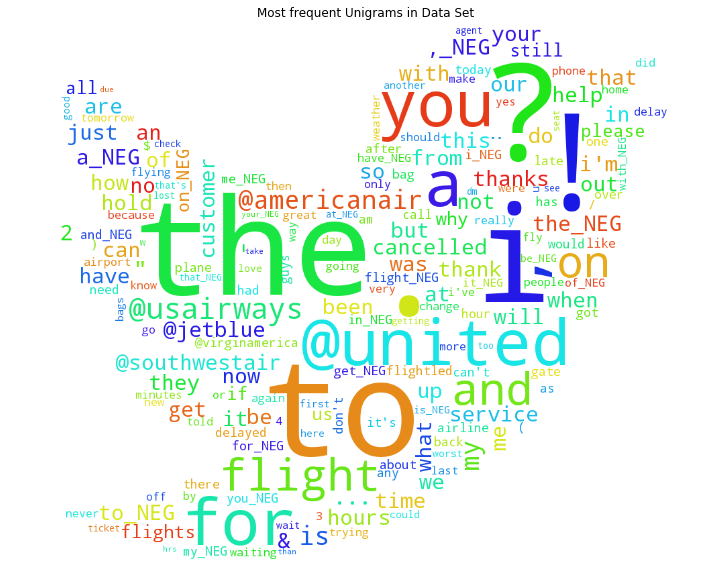

In [5]:
plot_word_cloud(unigrams)
plt.title("Most frequent Unigrams in Data Set")

## Most frequent bigrams

/usr/local/lib/python3.5/site-packages/wordcloud/wordcloud.py:286: UserWarning: mask image should be unsigned byte between 0 and 255. Got a float array
  warnings.warn("mask image should be unsigned byte between 0 and"


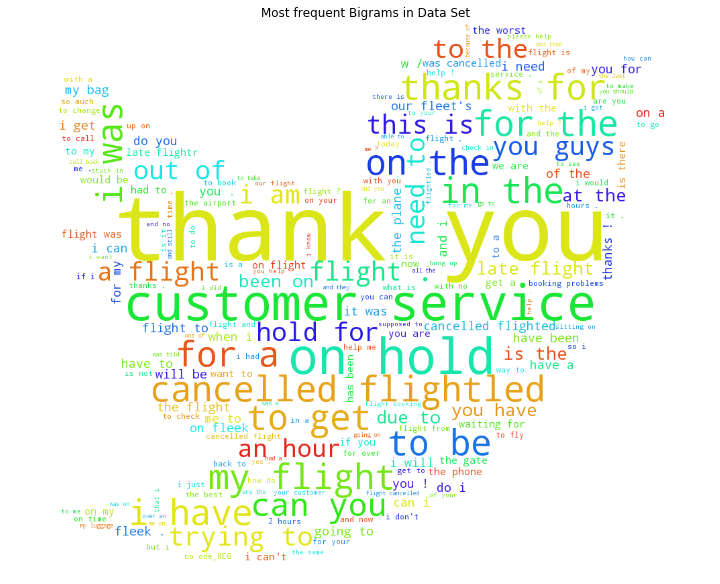

In [6]:
plot_word_cloud(bigrams)
plt.title("Most frequent Bigrams in Data Set")

## Visualizing features frequency distribution

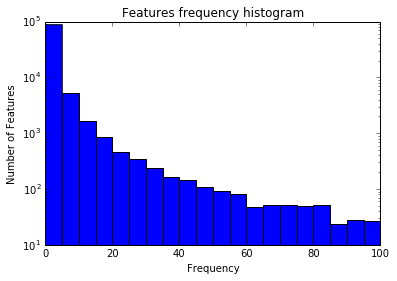

In [5]:
freq_list = []
for k, v in unigrams.items():
    freq_list.append(v)
for k, v in bigrams.items():
    freq_list.append(v)
freqs = pandas.Series(freq_list)
freqs.plot(kind='hist', bins = 20, range=(0, 100))
plt.ylabel("Number of Features")
plt.xlabel("Frequency")
plt.yscale('log', nonposy='clip')
plt.title("Features frequency histogram")

### Viewing number of features based on word min frequency

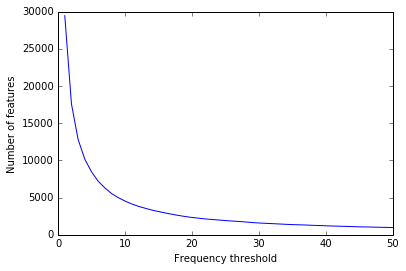

In [6]:
min_freq_range = list(range(1, 51))

features_count = [sum(freqs > x) for x in min_freq_range]
plt.plot(min_freq_range, features_count)
plt.xlabel("Frequency threshold")
plt.ylabel("Number of features")
plt.show()

## Exploring accuracy with various min_freq values

We will use a NaiveBayes classifier, with the default parameters, since it trains faster.

In [49]:
from nltk.sentiment import SentimentAnalyzer
from nltk.classify import NaiveBayesClassifier
from lib import classify

min_freq_range = list([10, 20, 30, 40])
accuracy = []
evaluations = []
for x in min_freq_range:
    print("Using min frequency of", x)
    sentim_analyzer = SentimentAnalyzer()
    classify.add_features(data, sentim_analyzer, min_freq = x)
    trainer = {
        'train': NaiveBayesClassifier.train,
    }
    e = classify.train_model(data, sentim_analyzer, trainer, sample_size = 3000)
    evaluations.append(e)

Using min frequency of 10
Unigram features 2173
Bigram features:  3266
Sampled 3000 elements
	Training fold 1
Training classifier
	Evaluating fold 1
Evaluating NaiveBayesClassifier results...
	Training fold 2
Training classifier
	Evaluating fold 2
Evaluating NaiveBayesClassifier results...
	Training fold 3
Training classifier
	Evaluating fold 3
Evaluating NaiveBayesClassifier results...
	Training fold 4
Training classifier
	Evaluating fold 4
Evaluating NaiveBayesClassifier results...
	Training fold 5
Training classifier
	Evaluating fold 5
Evaluating NaiveBayesClassifier results...
	Training fold 6
Training classifier
	Evaluating fold 6
Evaluating NaiveBayesClassifier results...
	Training fold 7
Training classifier
	Evaluating fold 7
Evaluating NaiveBayesClassifier results...
	Training fold 8
Training classifier
	Evaluating fold 8
Evaluating NaiveBayesClassifier results...
	Training fold 9
Training classifier
	Evaluating fold 9
Evaluating NaiveBayesClassifier results...
	Training fold 1

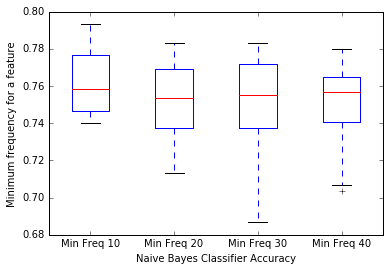

In [63]:
eval_data = [[evaluations[j][i]['Accuracy'] for j in range(len(min_freq_range))] for i in range(10)]
eval_df = pandas.DataFrame(eval_data, columns = ["Min Freq " + str(x) for x in min_freq_range])
eval_df.plot.box()
plt.ylabel("Minimum frequency for a feature")
plt.xlabel("Naive Bayes Classifier Accuracy")
plt.title("Exploring the ")

## Conclusion

We will chose to have as features only terms with frequency higher than 20, since it constitues a nice trade-off between accuracy and feature space and it allows us to train our models faster. 

## Bigrams

We will also use bigrams as features, since improving the feature space will results in better accuracy for our classifiers.